In [1]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Loading a mesh and do uniformly samplings on the surface.

import trimesh
import numpy as np

# Load your mesh using trimesh
# mesh = trimesh.load_mesh('slack_files/clip_20_15_1_15_10.obj')
# mesh = trimesh.load_mesh('cloth_hanger.obj')
mesh = trimesh.load_mesh('step2/reduced_mesh/segmentedHook.obj')

# the code below is for plotting the original mesh
# vertices = mesh.vertices
# faces = mesh.faces
# mp.plot(vertices, faces, shading={"wireframe": True})


# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)  # sample normally? 
print(type(points))
points_numpy = np.array(points)
points = torch.tensor(points)


# points = points.unsqueeze(0).float() # only do this after loading the input mesh?

# Plot the sampled points using MeshPlot
mp.plot(points_numpy, shading={'point_size':5})  # Here we're coloring the points based on their z-coordinate

<class 'trimesh.caching.TrackedArray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.5935592…

In [3]:
# Sample from a cylinder
# Parameters:
# center (x,y,z)
# axis (a_x, a_y, a_z)
# radius
#
# surface parameterization:
# u,v
#
# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v


# parameters[3:6] is the coordinates for the middle line  
def cylinder(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    radius = parameters[6]
    z_dir = axis / torch.linalg.norm(axis)

    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)

    # coordinates = torch.rand((1000,2)) (REMOVE THIS COMMENT IF REFACTERING COORDINATES!)
    u = coordinates[:,:1]
    v = coordinates[:,1:]

    return center + radius * x_dir * torch.cos(2*torch.pi*u) + radius * y_dir * torch.sin(2*torch.pi*u) + axis * v

# this function assumes that the cylinder param. is already optimal 
def cylinder_to_openscad(parameters):
    center = parameters[:3]
    axis = parameters[3:6]
    axis = np.array(axis)
    radius = parameters[6]
    return f"rod({radius}, {np.linalg.norm(axis)});"

cylinder_to_openscad([0.,0,0,3,1,6,1])

# example usage: 
# init_parameters = torch.tensor([0.,0,0,0,0,6,1])
# uv_coordinates = torch.rand((1000,2))
# points_cyl = cylinder(init_parameters, uv_coordinates).numpy()
# mp.plot(points_cyl, shading={'point_size':.2})

'rod(1, 6.782329983125268);'

  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/92/zc1_s6n94nz1z_gwqp60znxh0000gn/T/ipykernel_1435/1784473459.py:24: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/stanleyyang/pytorch/aten/src/ATen/native/Cross.cpp:66.)
  y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))


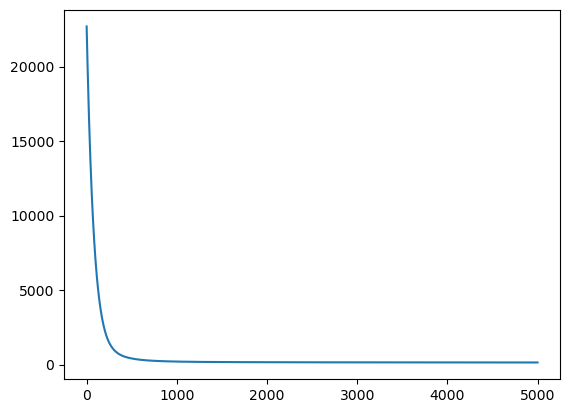

In [4]:
# diff. learning on a certain mesh input

import pytorch3d 
from pytorch3d.loss import chamfer_distance

opt_parameters_init_stage = torch.tensor([0.2,-0.2,0.3,0.1,-0.2,5.8,1.3]) # an initial parameter close to the given param
# opt_parameters_init_stage = torch.tensor([-22.,-232,773,881,-772,788,13]) # init param far from the given param

opt_params = torch.rand_like(opt_parameters_init_stage) # initializing it?
opt_params.requires_grad = True
optimizer = torch.optim.SGD([opt_params], 1e-3)
uv_coordinates = torch.rand((1000,2))
losses = []

## TODO: a different sampler (sample from the interior)!  write more primitive variants!
# fix on the messy types!
# connect w/ mingsheng 
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
# https://wias-berlin.de/software/index.jsp?id=TetGen&lang=1


points = points.view(1, -1, 3) 

for _ in tqdm(range(5000)): # for the progress bar
    optimizer.zero_grad()
    opt_points = cylinder(opt_params, uv_coordinates)
    # opt_points = torch.reshape(opt_points, (1, -1, 3))  # Assuming single batch, adjust N if needed
    opt_points = opt_points.view(1, -1, 3)

    # loss = ((points - opt_points)**2).sum() # TODO: change to champfer loss | volume matrix sampling | closed meshes?
    loss = chamfer_distance(x = points.float(), y = opt_points.float()) # returns a 2-element tuple? I suppose the first element is what we want
    loss = loss[0]
    
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())
plt.plot(losses)

In [5]:
points = points.reshape(-1, 1, 3)
# plot = mp.plot(points.numpy(), return_plot=True, shading={'point_size':.5})
plot = mp.plot(np.array(points), return_plot=True, shading={'point_size':.5})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':.5, 'point_color':'green'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.5935592…

1

In [6]:
# other primitives:

# Sample from a hole
# Parameters:
# center (x,y,z)
# axis (a_x, a_y, a_z)
# inner radius 
# outer radius
#

# surface parameterization:
# u,v
#
# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v

import numpy as np

def torus(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    # inner_radius = parameters[6]
    # outer_radius = parameters[7]
    R = parameters[6] ** 2
    r = parameters[7] ** 2
    z_dir = axis / torch.linalg.norm(axis)
    
    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)
    
    u = coordinates[:, :1]
    v = coordinates[:, 1:]

    return (center + x_dir * (R * torch.cos(2*torch.pi * u) + r * torch.cos(2*torch.pi * u) * torch.cos(2*torch.pi * v)) 
                   + y_dir * (R * torch.sin(2*torch.pi * u) + r * torch.sin(2*torch.pi * u) * torch.cos(2*torch.pi * v)) 
                   + z_dir * r * torch.sin(2*torch.pi * v)
    )
    # return np.stack((x, y, z), axis=-1)

# work on other param. and convert to openscad

# parameters = torch.tensor([0., 0, 0, 0, 0, 1, 3, 0.5])  # Center (x,y,z), axis (x,y,z), inner radius, outer radius
# coordinates = torch.rand((1000, 2))
# points = torus(parameters, coordinates).numpy()

# mp.plot(points, shading={'point_size':.2})

  0%|          | 0/5000 [00:00<?, ?it/s]

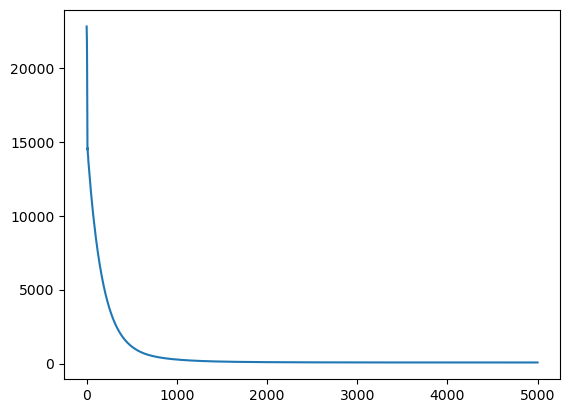

In [7]:
# diff. learning on a certain mesh input

import pytorch3d 
from pytorch3d.loss import chamfer_distance

opt_parameters_init_stage = torch.tensor([0.1,-0.1,0.1,0.1,-0.2,5,3, 2]) # an initial parameter close to the given param
# opt_parameters_init_stage = torch.tensor([-22.,-232,773,881,-772,788,13]) # init param far from the given param

opt_params = torch.rand_like(opt_parameters_init_stage) # initializing it?
opt_params.requires_grad = True
optimizer = torch.optim.SGD([opt_params], 1e-3)
uv_coordinates = torch.rand((1000,2))
losses = []

## TODO: a different sampler (sample from the interior)!  write more primitive variants!
# fix on the messy types!
# connect w/ mingsheng 
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
# https://wias-berlin.de/software/index.jsp?id=TetGen&lang=1

points = points.view(1, -1, 3) 

# WARNING: if you encounter an error at this line, where it says points.view not working,
# please simply load the mesh again and run this code block. it should work then.

for _ in tqdm(range(5000)): # for the progress bar
    optimizer.zero_grad()
    opt_points = torus(opt_params, uv_coordinates)
    # opt_points = torch.reshape(opt_points, (1, -1, 3))  # Assuming single batch, adjust N if needed
    opt_points = opt_points.view(1, -1, 3)

    # loss = ((points - opt_points)**2).sum() # TODO: change to champfer loss | volume matrix sampling | closed meshes?
    loss = chamfer_distance(x = points.float(), y = opt_points.float()) # returns a 2-element tuple? I suppose the first element is what we want
    loss = loss[0]
    
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())


plt.plot(losses)

In [8]:
print(opt_params)

points = points.reshape(-1, 1, 3)
# plot = mp.plot(points.numpy(), return_plot=True, shading={'point_size':.5})
plot = mp.plot(np.array(points), return_plot=True, shading={'point_size':5})




opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':5, 'point_color':'green'})

tensor([ 1.9850e+00, -2.5805e+01,  1.1417e+02,  1.9347e+00, -4.2628e-02,
         9.9565e-01,  3.3774e-15,  4.8285e+00], requires_grad=True)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.5935592…

1

In [9]:
import torch

def uniform_sampling_on_rectangle(vertices, num_samples=1000):
    """
    Perform uniform sampling on a rectangle defined by four vertices.
    
    Args:
        vertices (torch.Tensor): Tensor representing the four vertices of the rectangle (A, B, C, D).
                                  Each row contains the coordinates (x, y, z) of a vertex.
        num_samples (int): Number of points to sample. Default is 1000.
        
    Returns:
        sampled_points (torch.Tensor): Sampled points within the rectangle.
    """
    # Calculate lengths of the rectangle along each axis
    lengths_AB = torch.norm(vertices[1] - vertices[0])
    lengths_AD = torch.norm(vertices[3] - vertices[0])
    
    # Generate random points within the rectangle
    u = torch.rand(num_samples)
    v = torch.rand(num_samples)
    
    # Compute points within the rectangle
    points_on_rectangle = vertices[0] + u.view(-1, 1) * (vertices[1] - vertices[0]) + v.view(-1, 1) * (vertices[3] - vertices[0])
    
    return points_on_rectangle

# Example usage:
vertex_A = torch.tensor([0.0, 0.0, 0.0])
vertex_B = torch.tensor([1.0, 0.0, 0.0])
vertex_C = torch.tensor([1.0, 10.0, 0.0])
vertex_D = torch.tensor([0.0, 2.0, 0.0])

vertices = torch.stack([vertex_A, vertex_B, vertex_C, vertex_D])

sampled_points = uniform_sampling_on_rectangle(vertices)

# Print the sampled points
print("Sampled Points on the Rectangle:")
print(sampled_points)


plot = mp.plot(np.array(sampled_points), return_plot=True, shading={'point_size':.2})


Sampled Points on the Rectangle:
tensor([[0.6452, 1.7787, 0.0000],
        [0.9201, 0.8439, 0.0000],
        [0.2254, 1.2334, 0.0000],
        ...,
        [0.7621, 0.5073, 0.0000],
        [0.9132, 0.1460, 0.0000],
        [0.4942, 0.7811, 0.0000]])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4994356…

In [10]:
# other primitives:

# Sample from a hole
# Parameters:
# center (x,y,z)
# axis (a_x, a_y, a_z)
# inner radius 
# outer radius
#

# surface parameterization:
# u,v
#
# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v

import numpy as np

import torch
from pytorch3d.structures import Meshes

def rectangle(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    # param = sorted(parameters[7:]) # should we assume length >= width >= height?
    length = parameters[6]
    width = parameters[7]
    height = parameters[8]
    
    z_dir = axis / torch.linalg.norm(axis)
    
    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)
    
    u = coordinates[:, :1]
    v = coordinates[:, 1:] # we are not directly using u, v parametrization here.
    # idea: do a uniform sampling from each surface

    half_length = length / 2
    half_width = width / 2
    half_height = height / 2
    
    vertices = torch.tensor([
        [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1],
        [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]
    ], dtype=torch.float32)

    vertices = vertices * torch.tensor([half_length, half_width, half_height], dtype=torch.float32)
    vertices = vertices + center # Might need to do .unsqueeze(0)

    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face (ABFE)
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Top face (ABCD)
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Bottom face (EFGH)
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face (CDHG)
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Right face (ADHE)
        [vertices[1], vertices[3], vertices[7], vertices[5]]   # Left face (BFGC)
    ]
    
    # Sample points on each face
    sampled_points_on_faces = []
    for face_vertices in faces:
        sampled_points_on_face = uniform_sampling_on_rectangle(torch.stack(face_vertices), 1000)
        sampled_points_on_faces.append(sampled_points_on_face)
    
    # Combine points on all faces
    sampled_points = torch.cat(sampled_points_on_faces, dim=0)
    
    return sampled_points


parameters = torch.tensor([0., 0, 0, 0, 0, 1, 5, 3, 2])  # Center (x,y,z), axis (x,y,z), inner radius, outer radius
coordinates = torch.rand((1000, 2))
points = rectangle(parameters, coordinates).numpy()

mp.plot(points, shading={'point_size':.2})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [11]:
def hemisphere(parameters, coordinates, num_samples=1000):
    center = parameters[:3]
    axis = parameters[3:6]
    radius = parameters[6]
    z_dir = axis / torch.linalg.norm(axis) # assume the hemisphere is on the positive z-axis

    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)

    u = coordinates[:,:1]
    v = coordinates[:,1:]

    return (center + x_dir * radius * torch.sin(torch.pi / 2 * v) * torch.cos(2*torch.pi * u)
                   + y_dir * radius * torch.sin(torch.pi / 2 * v) * torch.sin(2*torch.pi * u) 
                   + z_dir * radius * torch.cos(torch.pi / 2 * v)
    )


parameters = torch.tensor([0., 0, 0, 0, 0, 1, 5])
coordinates = torch.rand((1000, 2))
points = hemisphere(parameters, coordinates).numpy()

mp.plot(points, shading={'point_size':.5})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002134…

In [12]:
# other primitives:

# Sample from a hole
# Parameters:
# center (x,y,z)
# axis (a_x, a_y, a_z)
# inner radius 
# outer radius
#

# surface parameterization:
# u,v
#
# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v

import numpy as np

def hook(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    R = parameters[6]
    r = parameters[7]
    u_range = parameters[8] % 360 # expected to be in range [0, 360]
    
    z_dir = axis / torch.linalg.norm(axis)
    
    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)
    
    u = coordinates[:, :1]
    v = coordinates[:, 1:]

    return (center + x_dir * (R * torch.cos(2*torch.pi * u_range / 360 * u) + r * torch.cos(2*torch.pi * u_range / 360 * u) * torch.cos(2*torch.pi * v)) 
                   + y_dir * (R * torch.sin(2*torch.pi * u_range / 360 * u) + r * torch.sin(2*torch.pi * u_range / 360 * u) * torch.cos(2*torch.pi * v)) 
                   + z_dir * r * torch.sin(2*torch.pi * v)
    )
    # return np.stack((x, y, z), axis=-1)

def tube(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    R = parameters[6]
    r = parameters[7]
    z_dir = axis / torch.linalg.norm(axis)

    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]))
    x_dir = torch.cross(y_dir, z_dir)

    # coordinates = torch.rand((1000,2)) (REMOVE THIS COMMENT IF REFACTERING COORDINATES!)
    u = coordinates[:,:1]
    v = coordinates[:,1:]

    sampled_points_on_faces = []
    sampled_points_on_faces.append(center + R * x_dir * torch.cos(2*torch.pi*u) + R * y_dir * torch.sin(2*torch.pi*u) + axis * v)
    sampled_points_on_faces.append(center + r * x_dir * torch.cos(2*torch.pi*u) + r * y_dir * torch.sin(2*torch.pi*u) + axis * v)
    return torch.cat(sampled_points_on_faces, dim=0)

# assume it doesn't take the height argument
def surface(parameters, coordinates):
    height = torch.tensor([0.1])
    parameters = torch.cat((parameters, height))
    return rectangle(parameters, coordinates)

def clip(parameters, coordinates):
    center = parameters[:3]
    axis = parameters[3:6]
    # param = sorted(parameters[7:]) # should we assume length >= width >= height?
    length = parameters[6]
    width = parameters[7]
    thickness = parameters[8]
    dist = parameters[9]
    open_gap = parameters[10]


parameters = torch.tensor([0., 0, 0, 0, 0, 1, 5, 3, 270])  # Center (x,y,z), axis (x,y,z), inner radius, outer radius
coordinates = torch.rand((1000, 2))
points = hook(parameters, coordinates).numpy()
# a tube without top and bottom faces?


mp.plot(points, shading={'point_size':5})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.069500…